In [2]:
# Major libraries
import scipy
import bottleneck 
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Preprocessing
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.preprocessing import scale
from scipy.spatial.distance import euclidean
from sklearn.model_selection import train_test_split
from matplotlib.colors import ListedColormap
from sklearn.datasets import make_classification
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix



In [2]:
df = pd.read_csv('diabetic_data.csv', na_values="?", low_memory=False)


In [7]:
# allow plots to appear in the notebook
%matplotlib inline


In [28]:
def ICD9_classifier(diagnoses):
    # Returns a series of strings corresponding to type of ICD9 diagnosis
    # diagnoses is a list
    gr_diagnoses = diagnoses.copy()
    icd9_dct = {
                'Infectious':(1, 139),
                'Neoplasmic':(140,239),
                'Hormonal':(240, 279),
                'Blood':(280,289),
                'Mental':(290,319),
                'Nervous':(320,359),
                'Sensory':(360,389),
                'Circulatory':(390,459),
                'Respiratory':(460,519),
                'Digestive':(520,579),
                'Genitourinary':(580,629),
                'Childbirth':(630,679),
                'Dermatological':(680,709),
                'Musculoskeletal':(710,739),
                'Congenital':(740,759),
                'Perinatal':(760,779),
                'Miscellaneous':(780,799),
                'Injury':(800,999)
               }
    for i, diagnosis in enumerate(diagnoses):
        if (str(diagnoses[i])[0] == 'E') or (str(diagnoses[i])[0] == 'V'):
            gr_diagnoses[i] = 'Accidental'
        elif (str(diagnoses[i]).lower() == 'nan'):
            gr_diagnoses[i] = 'NaN'
        else:
            for key, icd_range in icd9_dct.items():
                if (int(float(diagnoses[i])) >= icd_range[0]) and (int(float(diagnoses[i])) <= icd_range[1]):
                    gr_diagnoses[i] = key
    return gr_diagnoses



In [29]:
d1 = ICD9_classifier(df.diag_1.values)
d2 = ICD9_classifier(df.diag_2.values)
d3 = ICD9_classifier(df.diag_3.values)

xy = df.copy()

xy.diag_1 = d1
xy.diag_2 = d2
xy.diag_3 = d3

In [37]:

#Remove useless features
xy.drop(['encounter_id', 'weight', 'payer_code', 'medical_specialty', 'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone', 'tolazamide', 'examide', 'citoglipton', 'glyburide_metformin', 'glipizide_metformin', 'glimepiride_pioglitazone', 'metformin_rosiglitazone', 'metformin_pioglitazone' ], axis=1, inplace=True);


xy.race = df.race.map({'Other':0, 'AfricanAmerican':1, 'Asian':2, 'Caucasian':3, 'Hispanic':4, })
xy.gender = df.gender.map({'Female':1,'Male':0})
xy.insulin = df.insulin.map({'No':0, 'Steady':1, 'Up':2, 'Down':3 })
xy.max_glu_serum = df.max_glu_serum.map({'None':0, 'Norm':1, '>200':2, '>300':3 })
xy.A1Cresult = df.A1Cresult.map({'None':0, 'Norm':1, '>7':2, '>8':3 })
xy.change = df.change.map({'No':0, 'Ch':1})
xy.diabetesMed = df.diabetesMed.map({'No':0, 'Yes':1})


# Label-encode age feature to an integer in the center of the raw bin
xy.age = (LabelEncoder().fit_transform(xy.age)*10) + 5


lb = LabelEncoder()
xy['diag_1'] = lb.fit_transform(xy['diag_1']) 
#xy['medical_specialty'] = lb.fit_transform(xy['medical_specialty'])
xy['diag_2'] = lb.fit_transform(xy['diag_2'])
xy['diag_3'] = lb.fit_transform(xy['diag_3'])



In [38]:
le_readm = LabelEncoder()
xy.readmitted = pd.Series(le_readm.fit_transform(xy.readmitted),
                                                      index=xy.index)
le_readm.classes_ # 0 = <30, 1 = >30, 2 = NO

array(['<30', '>30', 'NO'], dtype=object)

In [41]:
xy.dropna(inplace=True)

In [42]:
xy.shape

(99492, 24)

In [43]:
num_features = xy.columns

# Remove outliers by class
for response in xy.readmitted.unique(): # For each readmission response
    response_df = xy[xy.readmitted==response] # For all samples that meet the readmission criteria
    for column in response_df[num_features].columns: # Iterate through each feature of the sample
        Q1 = response_df[column].quantile(0.25)
        Q3 = response_df[column].quantile(0.75)
        IQR = Q3-Q1
        if IQR > 0: # And remove features that are outside of Q1 - 1.5IQR or Q3 + 1.5IQR
            response_df = response_df[(response_df[column] > Q1-(1.5*IQR)) & (response_df[column] < Q3+(1.5*IQR))]
            xy = xy.drop(xy[xy.readmitted==response].index, axis=0)
            xy = xy.append(response_df)

In [44]:
xy.shape

(51611, 24)

In [45]:
xy.describe().ix[['min', 'max'],:]

C:\Users\CHANDIMA\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  """Entry point for launching an IPython kernel.


,patient_nbr,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,...,diag_1,diag_2,diag_3,number_diagnoses,max_glu_serum,A1Cresult,insulin,change,diabetesMed,readmitted
min,135.0,0.0,0.0,35.0,1.0,1.0,1.0,1.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
max,186173393.0,4.0,1.0,95.0,5.0,13.0,14.0,11.0,92.0,4.0,...,18.0,18.0,17.0,14.0,3.0,3.0,3.0,1.0,1.0,2.0


In [47]:
percent_null(xy)

Series([], dtype: float64)

In [55]:
y = xy.iloc[:,22:23]
x = xy.drop('readmitted', 1)


In [56]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=1)

In [59]:
import numpy as np
import matplotlib.pyplot as plt

In [60]:
from sklearn.datasets import make_classification
from sklearn.ensemble import ExtraTreesClassifier

In [62]:
# Build a forest and compute the feature importances
forest = ExtraTreesClassifier(n_estimators=250,
                              random_state=0)


In [63]:
forest.fit(x, y)
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

C:\Users\CHANDIMA\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """Entry point for launching an IPython kernel.


In [64]:
# Print the feature ranking
print("Feature ranking:")

for f in range(x.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))


Feature ranking:
1. feature 7 (0.093097)
2. feature 9 (0.088075)
3. feature 15 (0.076681)
4. feature 6 (0.074834)
5. feature 14 (0.070983)
6. feature 13 (0.070469)
7. feature 2 (0.063508)
8. feature 16 (0.055402)
9. feature 19 (0.050921)
10. feature 8 (0.049420)
11. feature 4 (0.044372)
12. feature 12 (0.037359)
13. feature 10 (0.035611)
14. feature 3 (0.033621)
15. feature 1 (0.030357)
16. feature 5 (0.027205)
17. feature 0 (0.025989)
18. feature 18 (0.025747)
19. feature 11 (0.023283)
20. feature 20 (0.015118)
21. feature 21 (0.006558)
22. feature 17 (0.001391)


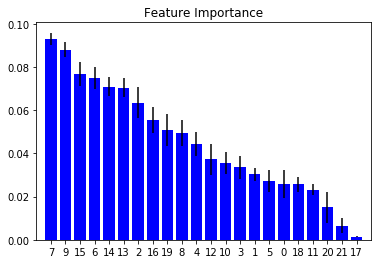

In [65]:
# Plot the feature importances of the forest
plt.figure()
plt.title("Feature Importance")
plt.bar(range(x.shape[1]), importances[indices],
       color="b", yerr=std[indices], align="center")
plt.xticks(range(x.shape[1]), indices)
plt.xlim([-1, x.shape[1]])
plt.show()

In [66]:
x.columns

Index(['race', 'gender', 'age', 'admission_type_id',
       'discharge_disposition_id', 'admission_source_id', 'time_in_hospital',
       'num_lab_procedures', 'num_procedures', 'num_medications',
       'number_outpatient', 'number_emergency', 'number_inpatient', 'diag_1',
       'diag_2', 'diag_3', 'number_diagnoses', 'max_glu_serum', 'A1Cresult',
       'insulin', 'change', 'diabetesMed'],
      dtype='object')

Feature importance of the selected 22 feature. From 22 features, some features have very low ranking.
Therefore, only the first 10 features with highest feature ranking will be considered for the final analysis.